## Demonstration of 1D and 1D time dilated convolutions

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorchiefs/dl_course_2025/blob/main/notebooks/09_1DConv_sol.ipynb)

in this notebook you will use 1D causal convolution to predict timeseries. You learn how 1D convolutions with causal padding work and see that dilated causal convolution are able capture long-range dependencies.

**Dataset:** We will use an articfical dataset with some long-range dependencies. We generate 1000 timeseries with the length of 128 timesteps that all follow the same pattern: a fast changing sine wave where the amplitude is modulated by an other sine wave with lower frequency. To make it a bit more challenging, we add some noise at each timestep of the waves. Our goal is to first predict the next 10 timesteps and then we want to predict for even longer timesteps in the future.

**Content:**
* creat articfical dataset with some long-range dependencies
* visualize a samples timeseries
* use keras to train a CNN with 1D causal convolutions
* predict the next 10 timesteps of the timeseries
* predict the next 80 timesteps of the timeseries
* use keras to train a CNN with 1D dilitated causal convolutions (which are abe to deal with long-range dependencies)
* predict the next 80 timesteps of the timeseries with 1D dilitated causal convolutions

In [1]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Lambda, Convolution1D
from tensorflow.keras.utils import to_categorical


# Signal generation
Generate a signal composed of:
1. fast oscillations
2. slow oscilations
3. random noise

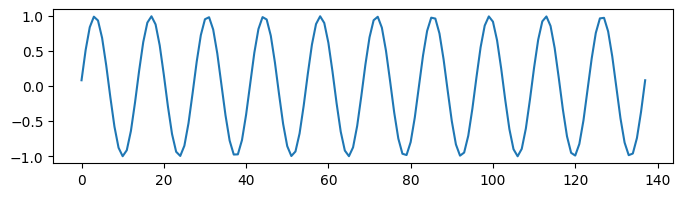

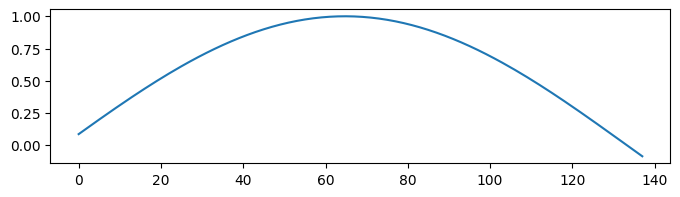

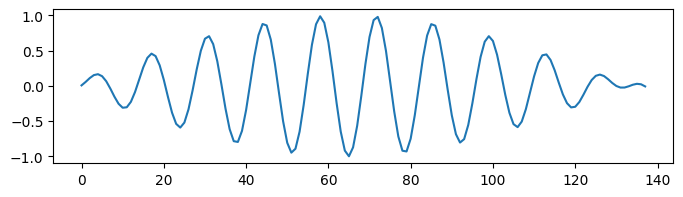

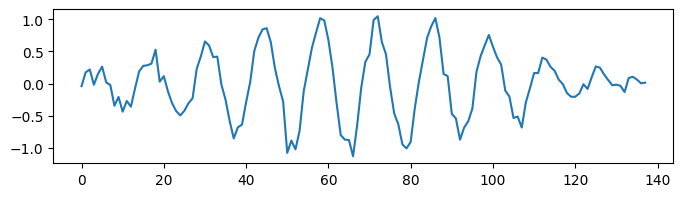

In [3]:
# process:fast sine wave * slow sine wave + random noise
start = np.random.uniform(0, 2*np.pi) # Random start point
s=128+10
# only fast oscillations
plt.figure(figsize=(8,2))
plt.plot(np.sin(start + np.linspace(0, 20*np.pi, s)))
plt.show()
# only slow oscillations
plt.figure(figsize=(8,2))
plt.plot(np.sin(start + np.linspace(0, np.pi, s)))
plt.show()
# multiply fast with slow
plt.figure(figsize=(8,2))
plt.plot(np.sin(start + np.linspace(0, 20*np.pi, s))*np.sin(start + np.linspace(0, np.pi, s)))
plt.show()
# add noise
plt.figure(figsize=(8,2))
plt.plot(np.sin(start + np.linspace(0, 20*np.pi, s))*np.sin(start + np.linspace(0, np.pi, s))+np.random.normal(0,0.1,s))
plt.show()


# Simulate some data

In the next cell we generate train and validation data. We multiply a fast sine wave with a slower sine wave and add a bit random noise. The goal is to learn from the past of time series and predict the next 10 steps and later even more than "only"  10 steps.

<ipython-input-4-d2bb7d1d24a8>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'b-',color='orange')


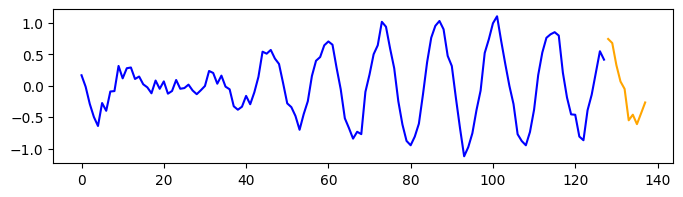

The training data X is the blue line and we want to forecast the next 10 steps Y, the orange line.


In [4]:
np.random.seed(1) # Fixing the seed, so data generation is always the same
seq_length = 128  # Sequence length used for training
look_ahead =  10  # The number of data points the model should predict

# create 1000 observations of the process, each with a different starting point and added random noise.
def gen_data(size=1000, noise=0.1,seq_length=128,look_ahead=10): # We create 1000 observations of the process
  s = seq_length + look_ahead
  d = np.zeros((size, s,1))
  for i in range(size):
    start = np.random.uniform(0, 2*np.pi) # Random start point
    d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
  return d[:,0:seq_length], d[:,seq_length:s]

# plot the first instance for example
X,Y = gen_data()
for i in range(1):
  plt.figure(num=None, figsize=(8,2))
  plt.plot(range(0, seq_length),X[i,:,0],'b-')
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'b-',color='orange')

plt.show()
print('The training data X is the blue line and we want to forecast the next 10 steps Y, the orange line.')

In [5]:
print(X.shape)
print(Y.shape)

(1000, 128, 1)
(1000, 10, 1)


# 1D Convolution without dilation rate

Here we define a Neural network with 1D convolutions and "causal" padding, in a later step we will also use a dilation rate.

In [6]:
def slice(x, slice_length):
    return x[:,-slice_length:,:]

model_1Dconv = Sequential()
ks = 5
model_1Dconv.add(Convolution1D(filters=8, activation="relu", kernel_size=ks, padding='causal', input_shape=(128, 1)))
model_1Dconv.add(Convolution1D(filters=8, activation="relu", kernel_size=ks, padding='causal'))
model_1Dconv.add(Convolution1D(filters=8, activation="relu", kernel_size=ks, padding='causal'))
model_1Dconv.add(Convolution1D(filters=8, activation="relu", kernel_size=ks, padding='causal'))
model_1Dconv.add(Dense(1))
model_1Dconv.add(Lambda(slice, arguments={'slice_length':look_ahead}))


model_1Dconv.compile(optimizer='adam', loss='mean_squared_error')
model_1Dconv.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 128, 8)         │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 128, 8)         │           328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 128, 8)         │           328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 128, 8)         │           328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128, 1)         │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 10, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,041 (4.07 KB)

 Trainable params: 1,041 (4.07 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model_1Dconv.fit(X[0:800], Y[0:800],
                    epochs=50,
                    batch_size=128,
                    validation_data=(X[800:1000], (Y[800:1000])),
                    verbose=1)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.5601 - val_loss: 0.3523
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3032 - val_loss: 0.2261
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2078 - val_loss: 0.1646
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1607 - val_loss: 0.1430
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1440 - val_loss: 0.1335
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1342 - val_loss: 0.1277
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1298 - val_loss: 0.1229
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.1238 - val_loss: 0.1187
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1170 - val_loss: 0.1144
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.1158 - val_loss: 0.1103
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1101 - val_loss: 0.1061
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1086 - val_loss: 0.1020
E

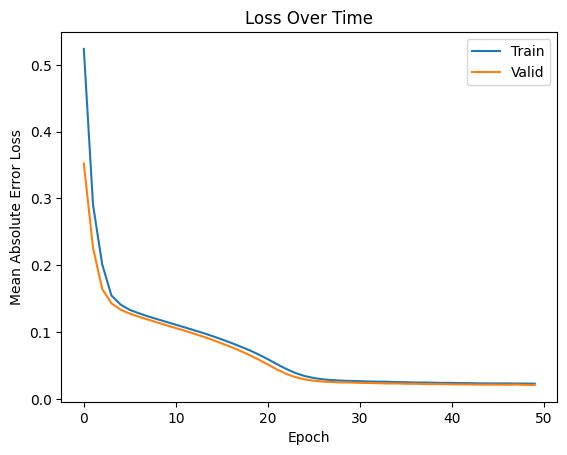

In [8]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

Now we want to use the trained model to predict for the next 10 steps, remember that is what the model was trained on.  
In addition,  we want to predict for longer than just 10 steps, we will  just predict the next 10 steps and take the predictions as new "true" observations and feed these values into the model, when we do that we can predict for any length we want. In the next cell we will predict the next 10 and 80 steps.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Text(0.5, 1.0, 'predict 80 steps ahead')

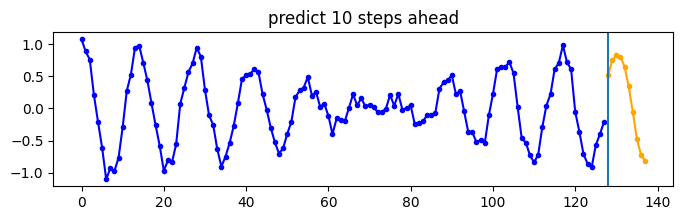

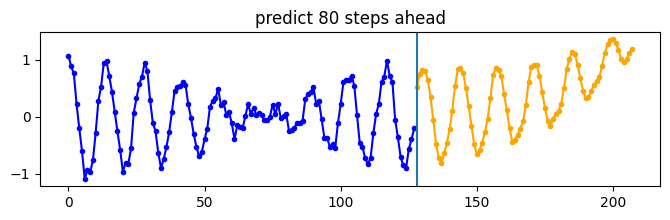

In [14]:
### predict for 10 steps
i=950
steps = 1 # number of iterations of 10 steps each
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]
plt.figure(num=None, figsize=(8,2))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],'.-',color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],'.-',color='orange')
plt.axvline(x=128)
plt.title("predict 10 steps ahead")

### predict for 80 steps
i=950
steps = 8
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]
plt.figure(num=None, figsize=(8,2))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],'.-',color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],'.-',color='orange')
plt.axvline(x=128)
plt.title("predict 80 steps ahead")



# 1D Convolution with dilation rate


Here we define a Neural network with 1D convolutions and "causal" padding, this time with dilation rate, so we are able to look back longer in time.

In [15]:

model_1Dconv_w_d = Sequential()
ks = 5
##################################################
###### your code here#############################

model_1Dconv_w_d.add(Convolution1D(filters=8, activation="relu",kernel_size=ks, padding='causal', input_shape=(128, 1)))
model_1Dconv_w_d.add(Convolution1D(filters=8, activation="relu", kernel_size=ks, padding='causal',dilation_rate=2))
model_1Dconv_w_d.add(Convolution1D(filters=8, activation="relu", kernel_size=ks, padding='causal',dilation_rate=4))
model_1Dconv_w_d.add(Convolution1D(filters=8, activation="relu",kernel_size=ks, padding='causal',dilation_rate=8))
model_1Dconv_w_d.add(Dense(1))
model_1Dconv_w_d.add(Lambda(slice, arguments={'slice_length':look_ahead}))

###### end of your code ##########################
##################################################

model_1Dconv_w_d.compile(optimizer='adam', loss='mean_squared_error')
model_1Dconv_w_d.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 128, 8)         │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 128, 8)         │           328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 128, 8)         │           328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 128, 8)         │           328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128, 1)         │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 10, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,041 (4.07 KB)

 Trainable params: 1,041 (4.07 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model_1Dconv_w_d.fit(X[0:800], Y[0:800],
                    epochs=50,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]),
                    verbose=1)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.2734 - val_loss: 0.2611
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2612 - val_loss: 0.2420
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2501 - val_loss: 0.2186
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2178 - val_loss: 0.1887
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1966 - val_loss: 0.1529
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1535 - val_loss: 0.1241
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1303 - val_loss: 0.1046
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1083 - val_loss: 0.0830
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0836 - val_loss: 0.0625
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0604 - val_loss: 0.0436
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0417 - val_loss: 0.0293
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0288 - val_loss: 0.0218
E

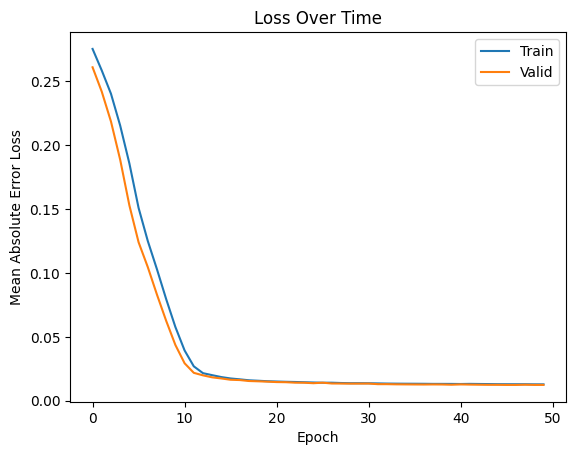

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Text(0.5, 1.0, 'predict 80 steps ahead')

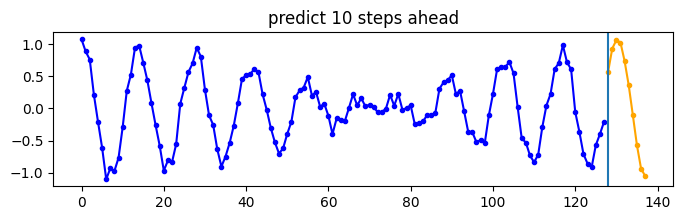

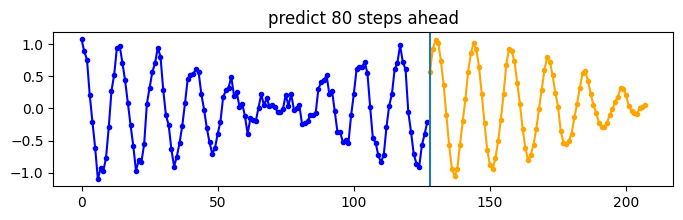

In [19]:
### predict for 10 steps
i=950
steps = 1
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv_w_d

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]
plt.figure(num=None, figsize=(8,2))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],'.-',color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],'.-',color='orange')
plt.axvline(x=128)
plt.title("predict 10 steps ahead")


### predict for 80 steps
i=950
steps = 8
pred = np.empty(0)
data = X[i:i+1]
model = model_1Dconv_w_d

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]
plt.figure(num=None, figsize=(8,2))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],'.-',color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],'.-',color='orange')
plt.axvline(x=128)
plt.title("predict 80 steps ahead")



#### Exercise:
Compare the long time predictions of the 1D Convolutional netural network with and without dilation.  
What do you observe and how do you exlain it.